<a href="https://colab.research.google.com/github/Yin-Zhang-TR/DeepLearning_CourseWork/blob/master/AX%202019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Run this to import the right things
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
import scipy.io as sio
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
#@title Load the SVHN data sets [RUN ME]
SVHN_DIR = './svhn_photos'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(SVHN_DIR):    
    TRAIN_DOWNLOAD_URL = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
    print('Downloading SVHN Train images from %s...' % TRAIN_DOWNLOAD_URL)
    urllib.request.urlretrieve(TRAIN_DOWNLOAD_URL, 'train_32x32.mat')
    #!tar xfz train.tgz
    
    TEST_DOWNLOAD_URL = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'
    print('Downloading SVHN Test images from %s...' % TEST_DOWNLOAD_URL)
    urllib.request.urlretrieve(TEST_DOWNLOAD_URL, 'test_32x32.mat')
    
    EXTRA_DOWNLOAD_URL = 'http://ufldl.stanford.edu/housenumbers/extra_32x32.mat'
    print('Downloading SVHN Extra images from %s...' % EXTRA_DOWNLOAD_URL)
    urllib.request.urlretrieve(EXTRA_DOWNLOAD_URL, 'extra_32x32.mat')
    #!tar xfz test.tgz
  print('SVHN photos are located in %s' % SVHN_DIR)
  
download_images()

# train_file = './svhn_photos/train/digitStruct.mat'
# test_file  = './svhn_photos/test/digitStruct.mat'

# train_data = h5py.File(train_file, 'r')
# test_data = h5py.File(test_file, 'r')


SVHN photos are located in ./svhn_photos


In [2]:
# !ls svhn_photos
# !rm -r test* train* svhn_photos
!ls

ls: cannot access 'svhn_photos': No such file or directory
base_line_fit_generator.h5	       extra_32x32.mat	test_32x32.mat
base_line_fit_generator_without_bn.h5  first_try.h5	train_32x32.mat
base_line.h5			       sample_data


In [4]:
train_file = './train_32x32.mat'
test_file  = './test_32x32.mat'
extra_file = './extra_32x32.mat'

# train_data, train_lables = sio.loadmat(train_file)
# test_data, test_lables = sio.loadmat(test_file)

train_data = sio.loadmat(train_file)
test_data = sio.loadmat(test_file)
extra_data = sio.loadmat(extra_file)
print(train_data.keys())
# print(train_data['X'])
print(train_data['X'].shape)
print(train_data['y'].reshape(len(train_data['y']),).shape)

print(train_data['X'].mean(axis=(3)).shape)
print(train_data['X'][:,:,:,np.where(train_data['y'] == 1)[0]].mean(axis=3).shape)
# print(train_data['X'][:,:,:,np.where(train_data['y'] == 1)[0]].mean(axis=3))
# print(train_data['X'][:,:,:,np.where(train_data['y'] == 1)].mean(axis=(4))[:,:,0,0])


train_data_std = train_data['X'][:,:,:,np.where(train_data['y'] == 1)[0]].std(axis=3)
print(train_data['X'][:,:,:,np.where(train_data['y'] == 1)[0]].std(axis=3).shape)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(32, 32, 3, 73257)
(73257,)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


(array([13861., 10585.,  8497.,  7458.,  6882.,  5727.,  5595.,  5045.,
         4659.,  4948.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

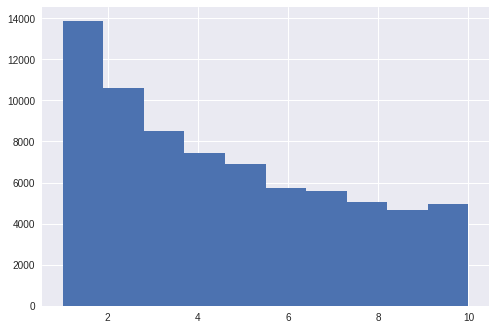

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.hist(train_data['y'], bins=10)

# plt.violinplot(train_data_std[:,:,0],
#                showmeans=False,
#                showmedians=True
#                )



In [4]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses

input_shape=(32, 32, 3)

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.5))
# # model.add(layers.Dense(11, activation='softmax'))
# model.add(layers.Dense(11, activation='sigmoid'))
# model.summary()

model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (3, 3), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(64, (3, 3), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(128, (3, 3), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(11, activation='softmax'))
model.summary()

lr = 0.1 #learning_rate
optimizers = {"SGD": optimizers.SGD(lr=lr), "RMSprop": optimizers.RMSprop(lr=lr),
              "Adadelta": optimizers.Adadelta(lr=lr), "Adam": optimizers.Adam(lr=lr)}

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers['SGD'],
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activat

In [5]:
batch_size = 64

traindata = train_data['X'].transpose(3,0,1,2).astype('float32')
testdata = test_data['X'].transpose(3,0,1,2).astype('float32')
trainlabel = train_data['y']
testlabel = test_data['y']
# print(traindata.shape)
# print(trainlabel.shape)
# print(train_data['y'].shape)

trainlabel = np_utils.to_categorical(trainlabel, 11)
testlabel = np_utils.to_categorical(testlabel, 11)

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)

train_generator      = data_generator.flow(traindata, trainlabel, batch_size=batch_size)
validation_generator = data_generator.flow(testdata, testlabel, batch_size=batch_size)

# model.compile(optimizer='rmsprop',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])


# model.fit(traindata, trainlabel, epochs=10, batch_size=batch_size)
# model.save('base_line_fit.h5')



# model.compile(optimizer='rmsprop',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=len(traindata)/batch_size,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=len(testdata)/batch_size)

model.save('base_line_fit_generator.h5')


Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1145/1144 [==============================] - 37s 32ms/step - loss: 1.4544 - acc: 0.4980 - val_loss: 0.4202 - val_acc: 0.8737
Epoch 2/10
1145/1144 [==============================] - 33s 29ms/step - loss: 0.4541 - acc: 0.8608 - val_loss: 0.3297 - val_acc: 0.9016
Epoch 3/10
1145/1144 [==============================] - 33s 29ms/step - loss: 0.3549 - acc: 0.8935 - val_loss: 0.2625 - val_acc: 0.9256
Epoch 4/10
1145/1144 [==============================] - 33s 29ms/step - loss: 0.3082 - acc: 0.9074 - val_loss: 0.2874 - val_acc: 0.9173
Epoch 5/10
1145/1144 [==============================] - 33s 29ms/step - loss: 0.2812 - acc: 0.9167 - val_loss: 0.2220 - val_acc: 0.9392
Epoch 6/10
1145/1144 [==============================] - 33s 29ms/step - loss: 0.2612 - acc: 0.9233 - val_loss: 0.2237 - val_acc: 0.9373
Epoch 7/10
1145/1144 [==============================] - 33s 29ms/step - loss: 0.2460 - acc: 0.9276 - val_loss: 0.2054 - val_acc: 0.9433


In [9]:
model.save('base_line.h5')

# evaluate the model on the test data
test_loss, test_acc = model.evaluate(testdata/255., testlabel)
print(test_acc, test_loss)

26032/26032 [==============================] - 5s 179us/step
0.8948217578365089 0.35584520163001937


In [5]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses

input_shape=(32, 32, 3)

model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding="same"))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (3, 3), padding="same"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(64, (3, 3), padding="same"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(128, (3, 3), padding="same"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(11, activation='softmax'))
model.summary()

lr = 0.1 #learning_rate
optimizers = {"SGD": optimizers.SGD(lr=lr), "RMSprop": optimizers.RMSprop(lr=lr),
              "Adadelta": optimizers.Adadelta(lr=lr), "Adam": optimizers.Adam(lr=lr)}

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers['SGD'],
              metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)  

In [0]:
batch_size = 64

traindata = train_data['X'].transpose(3,0,1,2).astype('float32')
testdata = test_data['X'].transpose(3,0,1,2).astype('float32')
extradata = extra_data['X'].transpose(3,0,1,2).astype('float32')
trainlabel = train_data['y']
testlabel = test_data['y']
extralabel = extra_data['y']


trainlabel = np_utils.to_categorical(trainlabel, 11)
testlabel = np_utils.to_categorical(testlabel, 11)

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)

train_generator      = data_generator.flow(traindata, trainlabel, batch_size=batch_size)
validation_generator = data_generator.flow(testdata, testlabel, batch_size=batch_size)

# model.compile(optimizer='rmsprop',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])


# model.fit(traindata, trainlabel, epochs=10, batch_size=batch_size)
# model.save('base_line_fit.h5')



# model.compile(optimizer='rmsprop',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

history_without_bn = model.fit_generator(
      train_generator,
      steps_per_epoch=len(traindata)/batch_size,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=len(testdata)/batch_size)

model.save('base_line_fit_generator_without_bn.h5')



Instructions for updating:
Use tf.cast instead.
Epoch 1/10


In [1]:
# model.save('base_line.h5')

# evaluate the model on the test data
test_loss, test_acc = model.evaluate(testdata/255., testlabel)
print(test_acc, test_loss)


# extradata = extra_data['X'].transpose(3,0,1,2).astype('float32')
# extralabel = extra_data['y']

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)

# train_generator      = data_generator.flow(traindata, trainlabel, batch_size=batch_size)
# validation_generator = data_generator.flow(testdata, testlabel, batch_size=batch_size)
# evaluation_generator = data_generator.flow(extradata, extralabel, batch_size=batch_size)

# model.evaluate_generator(evaluation_generator, verbose=1)
model.evaluate_generator(validation_generator, verbose=1)

NameError: ignored